Model Testing

Testing an array of binary classification models on a combined dataset of:
- DDI
- Fitzpatrick

In [1]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 92.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [2]:
import os
import sys
import glob

import numpy as np
import pandas as pd
from scipy import stats
from scipy import ndimage
import skimage.io

import torch
import torch.nn as nn
import timm
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, random_split
import torchvision
from torchvision import models, transforms
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import WeightedRandomSampler
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
from torchvision.models import MobileNet_V2_Weights
from torchvision.models import (VGG16_Weights, ResNet50_Weights, Inception_V3_Weights,
                                inception_v3, mobilenet_v2, MobileNet_V2_Weights)
from torchvision.models import alexnet, AlexNet_Weights
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_auc_score, roc_curve)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

from PIL import Image
import cv2 as cv
import copy
from tensorflow.keras import datasets, layers, models
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
df=pd.read_csv('/content/gdrive/MyDrive/Education/Masters/Final Year Project /Models Testing/combined_data.csv',index_col=0)
df.head()

,filename,skin_tone,malignant
0,000001.png,56,True
1,000002.png,56,True
2,000003.png,56,True
3,000004.png,56,True
4,000005.png,12,True


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16668 entries, 0 to 17232
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filename   16668 non-null  object
 1   skin_tone  16668 non-null  int64 
 2   malignant  16668 non-null  bool  
dtypes: bool(1), int64(1), object(1)
memory usage: 406.9+ KB


In [ ]:
df['filename'].count()

16668

In [ ]:
df['skin_tone'].value_counts()

12    7963
34    6330
56    2375
Name: skin_tone, dtype: int64

In [ ]:
# Get a list of all PNG files in the folder "combined_data"
png_images = glob.glob('/content/gdrive/MyDrive/Education/Masters/Final Year Project /Models Testing/combined_data/*.png')

# Get a list of all JPG files in the folder "combined_data"
jpg_images = glob.glob('/content/gdrive/MyDrive/Education/Masters/Final Year Project /Models Testing/combined_data/*.jpg')

# Concatenate the two lists
images = png_images + jpg_images

len(images)

17243

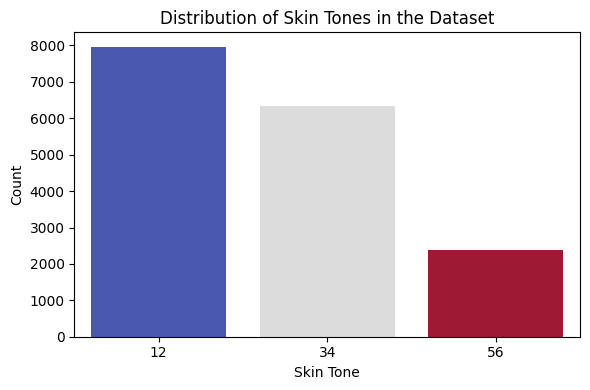

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x='skin_tone', data=df, hue='skin_tone', ax=ax, palette='coolwarm', legend=False)

# Set the title and labels
ax.set_title('Distribution of Skin Tones in the Dataset')
ax.set_xlabel('Skin Tone')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

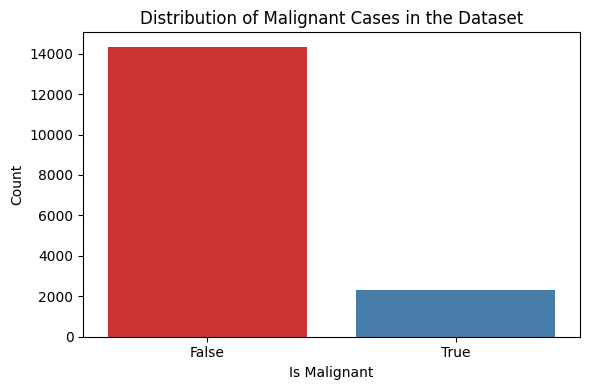

In [ ]:
#Distribution of data in 'malignant' column
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x='malignant', data=df, hue='malignant', ax=ax, palette='Set1', legend=False)
ax.set_title('Distribution of Malignant Cases in the Dataset')
ax.set_xlabel('Is Malignant')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

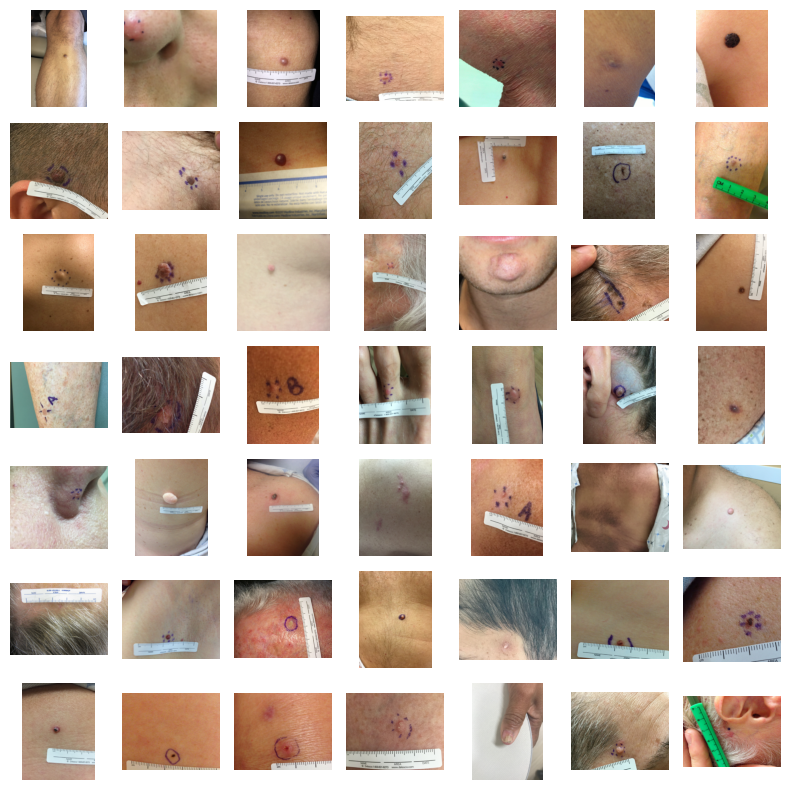

In [ ]:
plt.figure(figsize=(8, 8))
nrows, ncols = 7, 7
max_imgs = nrows * ncols  # Maximum number of images you can display

# Only loop through the first 'max_imgs' images
for i, file in enumerate(images[:max_imgs]):
    img = skimage.io.imread(file)

    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

Step 1: Define a Custom Dataset Class
This class will handle loading and transforming images on-the-fly.

In [6]:
class CustomDDIDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.ddi_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.ddi_frame['malignant'] = self.ddi_frame['malignant'].astype(int)

    def __len__(self):
        return len(self.ddi_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.ddi_frame.iloc[idx]['filename'])
        image = Image.open(img_name).convert('RGB')
        label = self.ddi_frame.iloc[idx]['malignant']
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

In [7]:
# Transformation with data augmentation for training
train_transform = T.Compose([

    T.Resize(299),  # Resize so the smallest side is 299 pixels
    T.RandomHorizontalFlip(),  # Randomly flip images horizontally
    T.RandomRotation(10),  # Randomly rotate images by up to 10 degrees
    T.RandomResizedCrop(299),  # Randomly crop and resize to 299x299
    T.ToTensor(),  # Convert image to a PyTorch tensor
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Transformation without data augmentation for validation/testing
val_transform = T.Compose([

    T.Resize(299),
    T.CenterCrop(299),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize the full dataset with transformations
full_dataset = CustomDDIDataset(csv_file='/content/gdrive/MyDrive/Education/Masters/Final Year Project /Models Testing/combined_data.csv',
                                root_dir='/content/gdrive/MyDrive/Education/Masters/Final Year Project /Models Testing/combined_data',
                                transform=train_transform)  # You might want to have a separate transform for full_dataset if necessary

# For training
train_dataset = CustomDDIDataset(csv_file='/content/gdrive/MyDrive/Education/Masters/Final Year Project /Models Testing/combined_data.csv',
                                root_dir='/content/gdrive/MyDrive/Education/Masters/Final Year Project /Models Testing/combined_data',
                                 transform=train_transform)

# For validation/testing
val_dataset = CustomDDIDataset(csv_file='/content/gdrive/MyDrive/Education/Masters/Final Year Project /Models Testing/combined_data.csv',
                                root_dir='/content/gdrive/MyDrive/Education/Masters/Final Year Project /Models Testing/combined_data',
                               transform=val_transform)

In [8]:
#Extracting the labels from the DataFrame and storing them as a numpy array
labels = df['malignant'].values
# Assuming binary classification with labels 0 and 1
class_sample_count = torch.tensor([
    (labels == 0).sum(),  # Count of class 0
    (labels == 1).sum()   # Count of class 1
])

In [9]:
#Computing class weights as the inverse of the class sample counts.
#If a class has more samples, it gets a lower weight.
#The weights are converted to float for correct division and to avoid integer division in Python.

class_weights = 1. / class_sample_count.float()

# Map each label in 'labels' to its corresponding weight
# If 'labels' is a numpy array:
samples_weights = np.array([class_weights[label].item() for label in labels])

# If 'labels' is a torch tensor:
samples_weights = torch.tensor([class_weights[label].item() for label in labels])

# Creating the WeightedRandomSampler with the computed sample weights
# This sampler will be used by a DataLoader to draw samples in a way that each class is represented equally, by sampling from the dataset according to the specified weights.
sampler = WeightedRandomSampler(weights=samples_weights, num_samples=len(samples_weights), replacement=True)

<ipython-input-9-29895cd48322>:9: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  samples_weights = np.array([class_weights[label].item() for label in labels])
<ipython-input-9-29895cd48322>:12: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  samples_weights = torch.tensor([class_weights[label].item() for label in labels])


In [10]:
# Splitting the dataset into training, validation, and test sets
train_idx, val_test_idx = train_test_split(range(len(full_dataset)), test_size=0.4, random_state=42)
val_idx, test_idx = train_test_split(val_test_idx, test_size=0.5, random_state=42)

# Creating train, validation, and test subsets
train_subset = Subset(full_dataset, train_idx)
val_subset = Subset(full_dataset, val_idx)
test_subset = Subset(full_dataset, test_idx)

# Creating DataLoader instances for all subsets
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, shuffle=False) #THIS LINE WAS CHANGED
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

In [11]:
def train_model(model, criterion, optimizer, scheduler, train_dataloader, val_dataloader, num_epochs=30, patience=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        # Training phase
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        train_loss = running_loss / len(train_dataloader.dataset)
        train_acc = running_corrects.double() / len(train_dataloader.dataset)

        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_corrects = 0

        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_dataloader.dataset)
        val_acc = val_corrects.double() / len(val_dataloader.dataset)

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        # Checkpointing
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            print('Validation loss decreased, saving model...')
        else:
            epochs_no_improve += 1
            print(f'Validation loss did not decrease, epochs with no improvement: {epochs_no_improve}.')

        if epochs_no_improve == patience:
            print('Early stopping triggered.')
            break

        scheduler.step()

    print('Training complete. Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

**Models Testing**
MobileNetV2 model

In [12]:
from torchvision import models
# Initialize the MobileNetV2 model with pre-trained weights
mobilenet_v2_model = models.mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)

# Modifying the classifier for binary classification
num_ftrs = mobilenet_v2_model.classifier[1].in_features
mobilenet_v2_model.classifier[1] = nn.Linear(num_ftrs, 2)

# Define the device and move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet_v2_model = mobilenet_v2_model.to(device)

# Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_v2_model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Call the updated train_model function with train and validation dataloaders
MobileNetV2_best_model = train_model(mobilenet_v2_model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=30, patience=5)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 187MB/s]


Epoch 1/30
Train Loss: 0.4922 Acc: 0.7624
Validation Loss: 0.3952 Acc: 0.8353
Validation loss decreased, saving model...
Epoch 2/30
Train Loss: 0.4256 Acc: 0.8005
Validation Loss: 0.3087 Acc: 0.8770
Validation loss decreased, saving model...
Epoch 3/30
Train Loss: 0.3868 Acc: 0.8240
Validation Loss: 0.3326 Acc: 0.8674
Validation loss did not decrease, epochs with no improvement: 1.
Epoch 4/30
Train Loss: 0.3570 Acc: 0.8419
Validation Loss: 0.3660 Acc: 0.8338
Validation loss did not decrease, epochs with no improvement: 2.
Epoch 5/30
Train Loss: 0.3352 Acc: 0.8488
Validation Loss: 0.2540 Acc: 0.8851
Validation loss decreased, saving model...
Epoch 6/30
Train Loss: 0.3109 Acc: 0.8655
Validation Loss: 0.2460 Acc: 0.8938
Validation loss decreased, saving model...
Epoch 7/30
Train Loss: 0.2984 Acc: 0.8698
Validation Loss: 0.2674 Acc: 0.8899
Validation loss did not decrease, epochs with no improvement: 1.
Epoch 8/30
Train Loss: 0.2530 Acc: 0.8898
Validation Loss: 0.2057 Acc: 0.9214
Validatio

Accuracy: 0.9352
Precision: 0.7136
Recall: 0.9325
F1 Score: 0.8085
ROC AUC Score: 0.9841
Confusion Matrix:
 [[2662  183]
 [  33  456]]


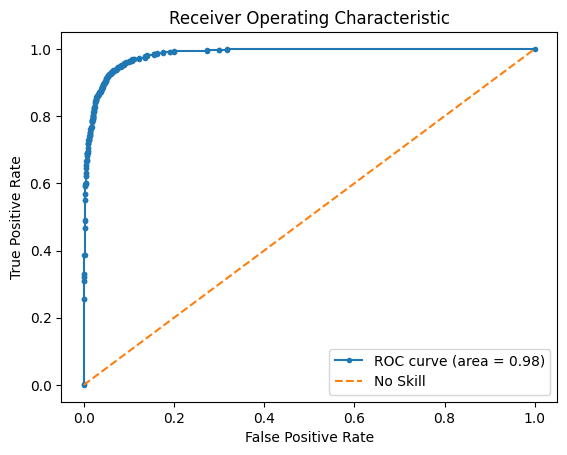

In [13]:
def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    true_labels = []
    predictions = []
    pred_probs = []  # Store prediction probabilities for ROC AUC calculation

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            # Assuming the model outputs logit scores, apply softmax to get probabilities
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # Get the probability of the positive class

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())
            pred_probs.extend(probs)  # Append probability of positive class

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    auc_score = roc_auc_score(true_labels, pred_probs)  # Calculate ROC AUC score
    conf_matrix = confusion_matrix(true_labels, predictions)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC Score: {auc_score:.4f}')
    print('Confusion Matrix:\n', conf_matrix)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(true_labels, pred_probs)
    plt.plot(fpr, tpr, marker='.', label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend()
    plt.show()

# Assuming your best_model is defined and test_dataloader is your validation/test dataloader
evaluate_model(MobileNetV2_best_model, test_loader, device)

In [16]:
torch.save(MobileNetV2_best_model.state_dict(), '/content/gdrive/MyDrive/Education/Masters/Final Year Project /Models Testing/MobileNetV2_model.pth')

In [18]:
# Create the Xception model with pre-trained weights using the updated model name
xception_model = timm.create_model('legacy_xception', pretrained=True)

# Modify the classifier for binary classification
num_ftrs = xception_model.fc.in_features
xception_model.fc = nn.Linear(num_ftrs, 2)

# Define the device and move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xception_model = xception_model.to(device)

# Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(xception_model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Xception_best_model = train_model(xception_model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=15, patience=3)

Epoch 1/15
Train Loss: 0.4410 Acc: 0.7894
Validation Loss: 0.2947 Acc: 0.8809
Validation loss decreased, saving model...
Epoch 2/15
Train Loss: 0.3242 Acc: 0.8574
Validation Loss: 0.2746 Acc: 0.8902
Validation loss decreased, saving model...
Epoch 3/15
Train Loss: 0.2617 Acc: 0.8892
Validation Loss: 0.1780 Acc: 0.9316
Validation loss decreased, saving model...
Epoch 4/15
Train Loss: 0.2173 Acc: 0.9083
Validation Loss: 0.1642 Acc: 0.9310
Validation loss decreased, saving model...
Epoch 5/15
Train Loss: 0.1879 Acc: 0.9209
Validation Loss: 0.1441 Acc: 0.9418
Validation loss decreased, saving model...
Epoch 6/15
Train Loss: 0.1670 Acc: 0.9323
Validation Loss: 0.1226 Acc: 0.9499
Validation loss decreased, saving model...
Epoch 7/15
Train Loss: 0.1566 Acc: 0.9369
Validation Loss: 0.1552 Acc: 0.9385
Validation loss did not decrease, epochs with no improvement: 1.
Epoch 8/15
Train Loss: 0.1379 Acc: 0.9482
Validation Loss: 0.1230 Acc: 0.9505
Validation loss did not decrease, epochs with no impr

In [19]:
def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    true_labels = []
    predictions = []
    pred_probs = []  # Store prediction probabilities for ROC AUC calculation

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            # Assuming the model outputs logit scores, apply softmax to get probabilities
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # Get the probability of the positive class

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())
            pred_probs.extend(probs)  # Append probability of positive class

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    auc_score = roc_auc_score(true_labels, pred_probs)  # Calculate ROC AUC score
    conf_matrix = confusion_matrix(true_labels, predictions)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC Score: {auc_score:.4f}')
    print('Confusion Matrix:\n', conf_matrix)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(true_labels, pred_probs)
    plt.plot(fpr, tpr, marker='.', label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend()
    plt.show()

Accuracy: 0.9691
Precision: 0.8459
Recall: 0.9652
F1 Score: 0.9016
ROC AUC Score: 0.9961
Confusion Matrix:
 [[2759   86]
 [  17  472]]


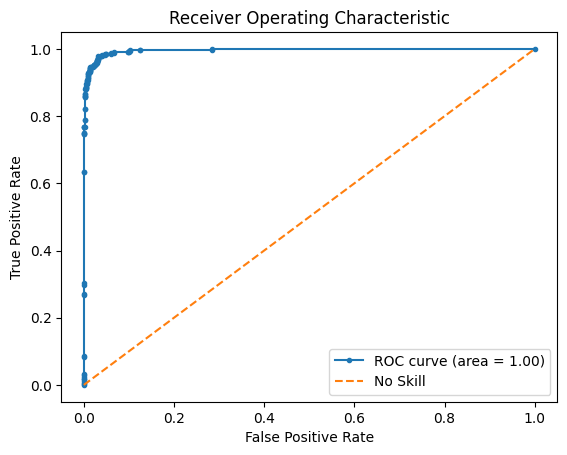

In [20]:
evaluate_model(Xception_best_model, test_loader, device)

In [21]:
torch.save(Xception_best_model.state_dict(), '/content/gdrive/MyDrive/Education/Masters/Final Year Project /Models Testing/Xception_model.pth')